In [1]:
import copy
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import tensorflow as tf
import deeppavlov
from deeppavlov.dataset_readers.ontonotes_reader import OntonotesReader

from deeppavlov.models.embedders.glove_embedder import GloVeEmbedder

2018-08-27 16:54:32.863 INFO in 'summarizer.preprocessing.cleaner'['textcleaner'] at line 37: 'pattern' package not found; tag filters are not available for English
2018-08-27 16:54:32.868 DEBUG in 'matplotlib.backends'['__init__'] at line 90: backend module://ipykernel.pylab.backend_inline version unknown


In [2]:
from src.fewshot_ner_viz_component.fewshot_ner_binary_classifier import FewshotNerBinaryClassifier, CompositeEmbedder
from src.fewshot_ner_viz_component.data_processing import *

### Configuration parameters

In [3]:
NE_TYPE = 'PERSON'
N_EXAMPLES = list(range(1, 11))
# N_EXAMPLES = list(range(1, 5))
N_TEST_SENTENCES = 100
N_SAMPLES = 10
# MODELS = ['ne_centroid', 'ne_nearest', 'weighted_kNN', 'centroid_kNN', 'svm']
MODELS = ['ne_centroid', 'ne_nearest', 'weighted_kNN', 'centroid_kNN', 'svm']
MODEL_PARAMS = {'ne_centroid': {'sim_type': 'cosine'},
               'ne_nearest': {'sim_type': 'cosine'},
               'weighted_kNN': {'k': 3, 'metric': 'cosine', 'use_class_weights': False, 'use_sim_weights': True},
               'centroid_kNN': {'k': 10, 'metric': 'dot_prod', 'use_class_weights': False},
               'svm': {}}

In [4]:
dataset_orig = read_data()

Num of train sentences: 75187
Num of valid sentences: 9603
Num of test sentences: 9479
[(['Actions', 'had', 'to', 'be', 'taken', 'to', 'break', 'through', 'the', 'blockade', '.'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'a', 'night', 'in', 'late', 'July', '1940', ',', 'the', 'atmosphere', 'in', 'Zhuanbi', 'Village', 'in', 'Shaanxi', 'was', 'unusual', '.'], ['O', 'B-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'B-GPE', 'I-GPE', 'O', 'B-GPE', 'O', 'O', 'O']), (['Villager', 'Xiao', 'Jianghe', 'has', 'a', 'vivid', 'memory', 'of', 'this', 'piece', 'of', 'history', '.'], ['O', 'B-PERSON', 'I-PERSON', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']), (['On', 'that', 'dark', 'night', ',', 'everyone', 'was', 'sleeping', 'when', 'human', 'voices', 'and', 'neighing', 'horses', 'were', 'heard', 'within', 'the', 'village', '.'], ['O', 'B-TIME', 'I-TIME', 'I-TIME', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

In [5]:
embedder = CompositeEmbedder(use_elmo=True, elmo_scale=1, cap_scale=1, use_cap_feat=True, use_glove=True, elmo_params={'trainable_cells': True, 'restore_path': "./tmp/elmo.ckpt"})

INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.


2018-08-27 16:54:33.851 INFO in 'tensorflow'['tf_logging'] at line 159: Using /tmp/tfhub_modules to cache modules.


Restoring finetuned ELMo params from ./tmp/elmo.ckpt
INFO:tensorflow:Restoring parameters from ./tmp/elmo.ckpt


2018-08-27 16:54:34.614 INFO in 'tensorflow'['tf_logging'] at line 115: Restoring parameters from ./tmp/elmo.ckpt
2018-08-27 16:54:34.842 INFO in 'deeppavlov.models.embedders.glove_embedder'['glove_embedder'] at line 96: [loading embeddings from `/home/clement/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt`]
2018-08-27 16:54:34.843 INFO in 'gensim.models.utils_any2vec'['utils_any2vec'] at line 170: loading projection weights from /home/clement/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt
2018-08-27 16:54:34.843 DEBUG in 'smart_open.smart_open_lib'['smart_open_lib'] at line 176: {'kw': {}, 'mode': 'rb', 'uri': '/home/clement/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt'}
2018-08-27 16:54:56.825 INFO in 'gensim.models.utils_any2vec'['utils_any2vec'] at line 232: loaded (400000, 100) matrix from /home/clement/DeepPavlov/download/embeddings/glove.6B/glove.6B.100d.txt


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:54:57.16 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


In [6]:
from collections import defaultdict
f1_scores = {}
print('NE type: {}'.format(NE_TYPE))
dataset = filter_dataset_by_ne_types(dataset_orig, NE_TYPE)
for n_ex in N_EXAMPLES:
    print('++++++++ Number of example sentences: {} ++++++++'.format(n_ex))
    f1_scores[n_ex] = {}
    for model in MODELS:
        f1_scores[n_ex][model] = {'values':[]}
    for idx_sample in range(N_SAMPLES):
        print('Sample {}'.format(idx_sample+1))
        tokens_train,tags_train = get_data_sample(dataset['train'], n_ex)
        tokens_test,tags_test = get_data_sample(dataset['test'], N_TEST_SENTENCES)
        y_test = np.array([1 if t == 'T' else 0 for seq in tags_test for t in seq])
        ner_bin_clf = FewshotNerBinaryClassifier(embedder)
        ner_bin_clf.train_on_batch(tokens_train, tags_train)
        results = ner_bin_clf.predict(tokens_test, MODELS, MODEL_PARAMS)
        pred_avg = np.zeros(y_test.size)
        n_models_avg = 0
        for model in MODELS:
            pred = results[model]['pred']
            if model in ['ne_centroid', 'weighted_kNN', 'centroid_kNN', 'svm']:   
                pred_avg += pred
                n_models_avg += 1
            f1 = f1_score(y_test, pred)
            f1_scores[n_ex][model]['values'].append(f1)
        pred_avg /= n_models_avg
        
        cur_f1_scores_dict = {k: f1_scores[n_ex][k]['values'][-1] for k in f1_scores[n_ex].keys()}
        print('F1 scores: {}'.format(cur_f1_scores_dict))
    for model in MODELS:
        f1_scores[n_ex][model]['mean'] = np.mean(f1_scores[n_ex][model]['values'])
        f1_scores[n_ex][model]['std'] = np.std(f1_scores[n_ex][model]['values'])
        print('{} F1: mean = {} std = {}'.format(model, f1_scores[n_ex][model]['mean'], f1_scores[n_ex][model]['std']))

NE type: PERSON
Num of train sentences: 12195
Num of valid sentences: 1553
Num of test sentences: 1573
++++++++ Number of example sentences: 1 ++++++++
Sample 1
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:00.298 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:01.215 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[=                   ] 5%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================] 100%
F1 scores: {'ne_centroid': 0.7037974683544302, 'ne_nearest': 0.7037974683544302, 'weighted_kNN': 0.6460807600950118, 'centroid_kNN': 0.0, 'svm': 0.1078838174273859}
Sample 2
Train


/home/clement/virtenv/env/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:07.801 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:08.641 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.79136690647482, 'ne_nearest': 0.79136690647482, 'weighted_kNN': 0.6742857142857143, 'centroid_kNN': 0.4658385093167701, 'svm': 0.33088235294117646}
Sample 3
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:17.535 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:18.619 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====                ] 16%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================] 100%
F1 scores: {'ne_centroid': 0.8257756563245824, 'ne_nearest': 0.8307692307692308, 'weighted_kNN': 0.7777777777777778, 'centroid_kNN': 0.0, 'svm': 0.17647058823529413}
Sample 4
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:24.734 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:25.653 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[===                 ] 12%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================] 100%
F1 scores: {'ne_centroid': 0.7684729064039408, 'ne_nearest': 0.7046070460704608, 'weighted_kNN': 0.7953488372093023, 'centroid_kNN': 0.0, 'svm': 0.0}
Sample 5
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:32.257 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:33.399 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[=======             ] 35%

/home/clement/fewshot_NER/notebooks/src/fewshot_ner_viz_component/fewshot_ner_binary_classifier.py:197: RuntimeWarning: invalid value encountered in true_divide
  calc_prob_dist = lambda ar: ar/(np.sum(ar))


[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[=======             ] 33%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================] 100%
F1 scores: {'ne_centroid': 0.40955631399317405, 'ne_nearest': 0.40955631399317405, 'weighted_kNN': 0.5128205128205128, 'centroid_kNN': 0.0, 'svm': 0.18569131832797428}
Sample 6
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:41.368 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:42.545 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.7807486631016042, 'ne_nearest': 0.64, 'weighted_kNN': 0.7175141242937854, 'centroid_kNN': 0.6727688787185354, 'svm': 0.8021390374331551}
Sample 7
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:51.385 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:52.567 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====                ] 18%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================] 100%
F1 scores: {'ne_centroid': 0.7267605633802816, 'ne_nearest': 0.2546816479400749, 'weighted_kNN': 0.7192307692307692, 'centroid_kNN': 0.0, 'svm': 0.8526077097505669}
Sample 8
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:58.557 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:55:59.838 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.608433734939759, 'ne_nearest': 0.5051194539249146, 'weighted_kNN': 0.6402753872633391, 'centroid_kNN': 0.0, 'svm': 0.7000000000000001}
Sample 9
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:56:08.778 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:56:10.344 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.6824324324324325, 'ne_nearest': 0.23788546255506612, 'weighted_kNN': 0.8461538461538463, 'centroid_kNN': 0.6819923371647509, 'svm': 0.8287292817679557}
Sample 10
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:56:21.677 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:56:23.107 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.44444444444444436, 'ne_nearest': 0.44444444444444436, 'weighted_kNN': 0.2578125, 'centroid_kNN': 0.6474358974358975, 'svm': 0.26356589147286824}
ne_centroid F1: mean = 0.674178908984947 std = 0.13703968438991582
ne_nearest F1: mean = 0.5522227974526616 std = 0.20253543329041432
weighted_kNN F1: mean = 0.658730022913006 std = 0.16057635910415025
centroid_kNN F1: mean = 0.2468035622635954 std = 0.30737441121777315
svm F1: mean = 0.42479699973563767 std = 0.31604531599580904
++++++++ Number of example sentences: 2 ++++++++
Sample 1
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:56:37.97 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:56:38.641 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8717948717948718, 'ne_nearest': 0.8159203980099503, 'weighted_kNN': 0.8590308370044054, 'centroid_kNN': 0.7533460803059274, 'svm': 0.8597285067873304}
Sample 2
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:56:57.591 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:56:59.457 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8590308370044053, 'ne_nearest': 0.3586626139817629, 'weighted_kNN': 0.8531187122736418, 'centroid_kNN': 0.7064516129032259, 'svm': 0.9155555555555556}
Sample 3
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:57:13.875 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:57:15.487 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8247978436657684, 'ne_nearest': 0.7598784194528875, 'weighted_kNN': 0.8103448275862069, 'centroid_kNN': 0.7163561076604554, 'svm': 0.8069164265129682}
Sample 4
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:57:29.858 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:57:31.842 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8114558472553698, 'ne_nearest': 0.6988636363636364, 'weighted_kNN': 0.709141274238227, 'centroid_kNN': 0.8050847457627118, 'svm': 0.7741935483870966}
Sample 5
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:57:46.229 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:57:47.932 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[===                 ] 13%

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[====================] 100%
F1 scores: {'ne_centroid': 0.7368421052631579, 'ne_nearest': 0.5906040268456375, 'weighted_kNN': 0.6930091185410334, 'centroid_kNN': 0.0, 'svm': 0.8311688311688312}
Sample 6
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:57:54.810 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:57:57.188 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.6821192052980133, 'ne_nearest': 0.5547945205479452, 'weighted_kNN': 0.7396449704142012, 'centroid_kNN': 0.6715686274509803, 'svm': 0.7220447284345047}
Sample 7
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:58:10.465 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:58:12.860 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.6875, 'ne_nearest': 0.21212121212121207, 'weighted_kNN': 0.6719367588932806, 'centroid_kNN': 0.614853195164076, 'svm': 0.7333333333333334}
Sample 8
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:58:26.464 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:58:29.0 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8682926829268293, 'ne_nearest': 0.8636363636363636, 'weighted_kNN': 0.8490566037735849, 'centroid_kNN': 0.6857142857142856, 'svm': 0.8932038834951457}
Sample 9
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:58:44.38 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:58:46.193 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.813953488372093, 'ne_nearest': 0.6947368421052631, 'weighted_kNN': 0.772972972972973, 'centroid_kNN': 0.6827309236947791, 'svm': 0.8421052631578947}
Sample 10
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:58:56.709 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:58:58.814 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.7331670822942643, 'ne_nearest': 0.6211180124223602, 'weighted_kNN': 0.7932489451476793, 'centroid_kNN': 0.5874125874125874, 'svm': 0.811659192825112}
ne_centroid F1: mean = 0.7888953963874773 std = 0.06929536153430377
ne_nearest F1: mean = 0.6170336045487018 std = 0.1920432213414337
weighted_kNN F1: mean = 0.7751505020845233 std = 0.06570094724518322
centroid_kNN F1: mean = 0.6223518166069029 std = 0.21567148611288378
svm F1: mean = 0.8189909269657771 std = 0.06009705190805275
++++++++ Number of example sentences: 3 ++++++++
Sample 1
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:59:09.846 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:59:12.564 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8120649651972158, 'ne_nearest': 0.43292682926829273, 'weighted_kNN': 0.8413793103448277, 'centroid_kNN': 0.8007889546351084, 'svm': 0.867579908675799}
Sample 2
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:59:32.804 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:59:35.445 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8029197080291971, 'ne_nearest': 0.34782608695652173, 'weighted_kNN': 0.8557919621749409, 'centroid_kNN': 0.708256880733945, 'svm': 0.8436018957345972}
Sample 3
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:59:52.770 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 16:59:55.367 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.7877358490566039, 'ne_nearest': 0.6929133858267716, 'weighted_kNN': 0.8840262582056893, 'centroid_kNN': 0.8391038696537679, 'svm': 0.8584070796460177}
Sample 4
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:00:14.951 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:00:17.921 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8557692307692307, 'ne_nearest': 0.5119453924914675, 'weighted_kNN': 0.8564476885644768, 'centroid_kNN': 0.6967071057192373, 'svm': 0.8409090909090909}
Sample 5
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:00:36.607 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:00:39.342 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8213333333333332, 'ne_nearest': 0.8064516129032258, 'weighted_kNN': 0.8463356973995272, 'centroid_kNN': 0.7544204322200393, 'svm': 0.8759493670886077}
Sample 6
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:00:58.792 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:01:02.9 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.7651715039577837, 'ne_nearest': 0.6985915492957746, 'weighted_kNN': 0.8672985781990521, 'centroid_kNN': 0.7777777777777777, 'svm': 0.848780487804878}
Sample 7
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:01:19.943 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:01:23.53 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8215158924205378, 'ne_nearest': 0.35471698113207545, 'weighted_kNN': 0.7819548872180451, 'centroid_kNN': 0.7069271758436944, 'svm': 0.8454106280193235}
Sample 8
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:01:43.875 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:01:47.599 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.844559585492228, 'ne_nearest': 0.6434782608695653, 'weighted_kNN': 0.8203753351206435, 'centroid_kNN': 0.8384074941451991, 'svm': 0.8475452196382429}
Sample 9
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:02:16.417 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:02:19.467 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8305489260143198, 'ne_nearest': 0.7192982456140351, 'weighted_kNN': 0.6746268656716418, 'centroid_kNN': 0.7596899224806201, 'svm': 0.8856447688564477}
Sample 10
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:02:38.179 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:02:41.313 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.7774798927613941, 'ne_nearest': 0.5675675675675675, 'weighted_kNN': 0.7774480712166173, 'centroid_kNN': 0.836027713625866, 'svm': 0.8333333333333334}
ne_centroid F1: mean = 0.8119098887031843 std = 0.02748320893591089
ne_nearest F1: mean = 0.5775715911925298 std = 0.15249325145956202
weighted_kNN F1: mean = 0.8205684654115462 std = 0.058723942687185976
centroid_kNN F1: mean = 0.7718107326835255 std = 0.05319917100449288
svm F1: mean = 0.8547161779706339 std = 0.015909624966382322
++++++++ Number of example sentences: 4 ++++++++
Sample 1
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:03:03.477 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:03:06.920 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.7869674185463659, 'ne_nearest': 0.6627565982404693, 'weighted_kNN': 0.8257756563245824, 'centroid_kNN': 0.8421052631578947, 'svm': 0.8592233009708736}
Sample 2
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:03:37.900 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:03:41.358 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8511749347258485, 'ne_nearest': 0.849604221635884, 'weighted_kNN': 0.8794326241134752, 'centroid_kNN': 0.8205128205128206, 'svm': 0.8697788697788698}
Sample 3
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:04:03.753 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:04:07.744 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.7409470752089137, 'ne_nearest': 0.6506024096385543, 'weighted_kNN': 0.8557919621749409, 'centroid_kNN': 0.7297297297297297, 'svm': 0.8585365853658536}
Sample 4
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:04:34.272 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:04:37.962 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.7670454545454546, 'ne_nearest': 0.574468085106383, 'weighted_kNN': 0.7709750566893424, 'centroid_kNN': 0.7664399092970521, 'svm': 0.8759894459102903}
Sample 5
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:04:57.831 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:05:02.210 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8883248730964467, 'ne_nearest': 0.3206751054852321, 'weighted_kNN': 0.8987012987012987, 'centroid_kNN': 0.8726415094339622, 'svm': 0.8952879581151832}
Sample 6
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:05:25.689 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:05:29.622 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8391959798994973, 'ne_nearest': 0.3725490196078431, 'weighted_kNN': 0.831275720164609, 'centroid_kNN': 0.8583509513742072, 'svm': 0.8955916473317865}
Sample 7
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:05:57.551 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:06:01.546 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.7692307692307692, 'ne_nearest': 0.7729729729729731, 'weighted_kNN': 0.8256410256410257, 'centroid_kNN': 0.7999999999999999, 'svm': 0.8229166666666666}
Sample 8
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:06:28.337 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:06:32.352 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.880952380952381, 'ne_nearest': 0.7361963190184048, 'weighted_kNN': 0.7990074441687345, 'centroid_kNN': 0.6724738675958187, 'svm': 0.8297362110311751}
Sample 9
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:06:54.255 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:06:59.110 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8979591836734694, 'ne_nearest': 0.54375, 'weighted_kNN': 0.8411633109619686, 'centroid_kNN': 0.7735470941883767, 'svm': 0.9152542372881356}
Sample 10
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:07:14.450 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:07:18.998 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.5314183123877917, 'ne_nearest': 0.3321033210332104, 'weighted_kNN': 0.7471910112359551, 'centroid_kNN': 0.8068459657701711, 'svm': 0.7818574514038876}
ne_centroid F1: mean = 0.7953216382266938 std = 0.10281676303287694
ne_nearest F1: mean = 0.5815678052738955 std = 0.17866555559706254
weighted_kNN F1: mean = 0.8274955110175932 std = 0.043853001279979924
centroid_kNN F1: mean = 0.7942647111060034 std = 0.05798279444296465
svm F1: mean = 0.8604172373862722 std = 0.037834715763512335
++++++++ Number of example sentences: 5 ++++++++
Sample 1
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:07:42.43 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:07:46.666 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8140703517587939, 'ne_nearest': 0.25671641791044775, 'weighted_kNN': 0.8366890380313199, 'centroid_kNN': 0.7386363636363636, 'svm': 0.8341013824884792}
Sample 2
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:08:08.889 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:08:14.433 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8586387434554974, 'ne_nearest': 0.540192926045016, 'weighted_kNN': 0.8641304347826086, 'centroid_kNN': 0.8938271604938272, 'svm': 0.9072164948453609}
Sample 3
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:08:45.434 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:08:50.108 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8195121951219512, 'ne_nearest': 0.3787878787878788, 'weighted_kNN': 0.8491048593350384, 'centroid_kNN': 0.8092243186582809, 'svm': 0.870886075949367}
Sample 4
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:09:16.79 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:09:20.877 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.87527352297593, 'ne_nearest': 0.7927927927927927, 'weighted_kNN': 0.8761061946902655, 'centroid_kNN': 0.8767676767676768, 'svm': 0.8486238532110092}
Sample 5
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:09:54.498 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:09:59.416 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8414985590778099, 'ne_nearest': 0.8148148148148149, 'weighted_kNN': 0.8504398826979472, 'centroid_kNN': 0.8413098236775819, 'svm': 0.8659217877094972}
Sample 6
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:10:23.521 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:10:28.534 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8287292817679558, 'ne_nearest': 0.6322188449848024, 'weighted_kNN': 0.9032258064516129, 'centroid_kNN': 0.8911917098445595, 'svm': 0.9066666666666665}
Sample 7
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:10:59.851 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:11:05.85 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8443271767810027, 'ne_nearest': 0.4360902255639098, 'weighted_kNN': 0.8181818181818182, 'centroid_kNN': 0.7862068965517243, 'svm': 0.8507462686567164}
Sample 8
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:11:32.563 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:11:37.983 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8488888888888889, 'ne_nearest': 0.6816901408450705, 'weighted_kNN': 0.8526785714285713, 'centroid_kNN': 0.8228346456692913, 'svm': 0.881578947368421}
Sample 9
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:12:07.362 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:12:12.994 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8701594533029612, 'ne_nearest': 0.7692307692307692, 'weighted_kNN': 0.9038031319910513, 'centroid_kNN': 0.8742268041237115, 'svm': 0.9029345372460498}
Sample 10
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:12:46.94 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:12:52.541 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8872901678657075, 'ne_nearest': 0.8471177944862155, 'weighted_kNN': 0.8861985472154963, 'centroid_kNN': 0.8148148148148148, 'svm': 0.8695652173913044}
ne_centroid F1: mean = 0.8488388340996499 std = 0.022968315738435916
ne_nearest F1: mean = 0.6149652605461717 std = 0.19383348179000934
weighted_kNN F1: mean = 0.8640558284805729 std = 0.026723371179222136
centroid_kNN F1: mean = 0.8349040214237832 std = 0.04777832820457524
svm F1: mean = 0.8738241231532872 std = 0.024363889392479625
++++++++ Number of example sentences: 6 ++++++++
Sample 1
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:13:21.48 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:13:26.910 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8109452736318408, 'ne_nearest': 0.625, 'weighted_kNN': 0.859375, 'centroid_kNN': 0.8388625592417062, 'svm': 0.8556701030927835}
Sample 2
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:13:58.795 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:14:05.505 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.838445807770961, 'ne_nearest': 0.199288256227758, 'weighted_kNN': 0.8383233532934132, 'centroid_kNN': 0.7346278317152104, 'svm': 0.8356435643564357}
Sample 3
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:14:35.51 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:14:41.383 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.82903981264637, 'ne_nearest': 0.7371273712737128, 'weighted_kNN': 0.7687687687687688, 'centroid_kNN': 0.8149882903981266, 'svm': 0.8195121951219513}
Sample 4
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:15:06.425 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:15:12.737 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.7990430622009569, 'ne_nearest': 0.3984220907297831, 'weighted_kNN': 0.8229665071770335, 'centroid_kNN': 0.8125000000000001, 'svm': 0.7831858407079647}
Sample 5
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:15:45.167 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:15:52.8 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8578199052132702, 'ne_nearest': 0.6880466472303207, 'weighted_kNN': 0.8717948717948718, 'centroid_kNN': 0.8818181818181818, 'svm': 0.8672985781990521}
Sample 6
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:16:33.785 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:16:40.630 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8272251308900525, 'ne_nearest': 0.576271186440678, 'weighted_kNN': 0.8774509803921569, 'centroid_kNN': 0.8530120481927711, 'svm': 0.8487804878048781}
Sample 7
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:17:15.467 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:17:22.139 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8009828009828011, 'ne_nearest': 0.5939393939393939, 'weighted_kNN': 0.8660287081339713, 'centroid_kNN': 0.8666666666666667, 'svm': 0.6829268292682926}
Sample 8
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:18:00.962 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:18:08.917 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8816120906801007, 'ne_nearest': 0.564935064935065, 'weighted_kNN': 0.891041162227603, 'centroid_kNN': 0.9126213592233011, 'svm': 0.8983451536643026}
Sample 9
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:18:44.4 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:18:51.129 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8687350835322196, 'ne_nearest': 0.672514619883041, 'weighted_kNN': 0.892018779342723, 'centroid_kNN': 0.8805620608899298, 'svm': 0.9009433962264151}
Sample 10
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:19:24.733 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:19:31.941 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8534704370179949, 'ne_nearest': 0.7667731629392971, 'weighted_kNN': 0.8564102564102565, 'centroid_kNN': 0.8262910798122065, 'svm': 0.8814432989690721}
ne_centroid F1: mean = 0.8367319404566567 std = 0.026979990508316846
ne_nearest F1: mean = 0.5822317793599049 std = 0.16128502152399435
weighted_kNN F1: mean = 0.8544178387540798 std = 0.03512110878014917
centroid_kNN F1: mean = 0.8421950077958101 std = 0.0470898126744442
svm F1: mean = 0.8373749447411148 std = 0.06178455485537546
++++++++ Number of example sentences: 7 ++++++++
Sample 1
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:20:00.551 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:20:09.217 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8585858585858587, 'ne_nearest': 0.5754189944134078, 'weighted_kNN': 0.7534883720930232, 'centroid_kNN': 0.7355371900826446, 'svm': 0.7702407002188184}
Sample 2
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:20:44.165 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:20:51.844 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8216704288939052, 'ne_nearest': 0.6242774566473989, 'weighted_kNN': 0.8747252747252747, 'centroid_kNN': 0.8634361233480176, 'svm': 0.8736141906873615}
Sample 3
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:21:34.777 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:21:42.482 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8246445497630331, 'ne_nearest': 0.4367088607594936, 'weighted_kNN': 0.8552915766738661, 'centroid_kNN': 0.8948545861297539, 'svm': 0.8214285714285715}
Sample 4
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:22:28.135 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:22:36.957 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8394495412844037, 'ne_nearest': 0.6947368421052632, 'weighted_kNN': 0.8976034858387799, 'centroid_kNN': 0.8950749464668094, 'svm': 0.902542372881356}
Sample 5
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:23:09.61 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:23:16.949 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8191489361702128, 'ne_nearest': 0.2834008097165992, 'weighted_kNN': 0.8730158730158729, 'centroid_kNN': 0.875, 'svm': 0.8753315649867375}
Sample 6
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:23:53.363 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:24:01.422 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8671679197994988, 'ne_nearest': 0.3187250996015936, 'weighted_kNN': 0.8762376237623762, 'centroid_kNN': 0.8639618138424822, 'svm': 0.8740740740740741}
Sample 7
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:24:44.385 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:24:52.813 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.834319526627219, 'ne_nearest': 0.604361370716511, 'weighted_kNN': 0.6711409395973154, 'centroid_kNN': 0.9028871391076115, 'svm': 0.8978494623655914}
Sample 8
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:25:30.200 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:25:38.761 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.7777777777777778, 'ne_nearest': 0.7045454545454547, 'weighted_kNN': 0.8139534883720931, 'centroid_kNN': 0.811279826464208, 'svm': 0.8275862068965518}
Sample 9
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:26:15.941 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:26:24.492 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8509485094850948, 'ne_nearest': 0.6171003717472119, 'weighted_kNN': 0.8791208791208792, 'centroid_kNN': 0.9048843187660669, 'svm': 0.8854961832061069}
Sample 10
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:27:02.870 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:27:11.698 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8517647058823531, 'ne_nearest': 0.32869080779944293, 'weighted_kNN': 0.8847926267281107, 'centroid_kNN': 0.8658823529411764, 'svm': 0.8822170900692842}
ne_centroid F1: mean = 0.8345477754269357 std = 0.024403373239478644
ne_nearest F1: mean = 0.5187966068052378 std = 0.15332751431798386
weighted_kNN F1: mean = 0.8379370139927591 std = 0.06879780529969673
centroid_kNN F1: mean = 0.8612798297148769 std = 0.049431138491295074
svm F1: mean = 0.8610380416814453 std = 0.03948282924551054
++++++++ Number of example sentences: 8 ++++++++
Sample 1
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:27:47.633 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:27:57.99 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.7835051546391751, 'ne_nearest': 0.5234159779614325, 'weighted_kNN': 0.8831775700934579, 'centroid_kNN': 0.8593350383631715, 'svm': 0.9004524886877828}
Sample 2
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:29:16.873 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:29:26.69 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8249999999999998, 'ne_nearest': 0.7401129943502825, 'weighted_kNN': 0.8813559322033899, 'centroid_kNN': 0.8735083532219571, 'svm': 0.8685446009389672}
Sample 3
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:30:04.53 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:30:13.694 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8697788697788698, 'ne_nearest': 0.6024096385542168, 'weighted_kNN': 0.8737373737373737, 'centroid_kNN': 0.8721804511278196, 'svm': 0.8762376237623762}
Sample 4
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:31:09.700 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:31:19.349 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8343815513626835, 'ne_nearest': 0.3551401869158879, 'weighted_kNN': 0.8303571428571428, 'centroid_kNN': 0.8583509513742071, 'svm': 0.8969696969696969}
Sample 5
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:32:13.115 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:32:22.963 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.843956043956044, 'ne_nearest': 0.7468030690537084, 'weighted_kNN': 0.7686274509803922, 'centroid_kNN': 0.7602996254681648, 'svm': 0.7743190661478598}
Sample 6
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:32:57.59 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:33:07.397 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.861244019138756, 'ne_nearest': 0.64576802507837, 'weighted_kNN': 0.8771084337349396, 'centroid_kNN': 0.8285714285714285, 'svm': 0.8617511520737327}
Sample 7
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:33:56.967 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:34:07.325 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.7607843137254902, 'ne_nearest': 0.41420118343195267, 'weighted_kNN': 0.9032258064516129, 'centroid_kNN': 0.8877284595300261, 'svm': 0.8967136150234742}
Sample 8
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:34:46.150 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:34:56.535 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.7959697732997479, 'ne_nearest': 0.5458248472505091, 'weighted_kNN': 0.8421052631578947, 'centroid_kNN': 0.8463356973995273, 'svm': 0.836272040302267}
Sample 9
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:35:46.803 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:35:57.788 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8997289972899729, 'ne_nearest': 0.7156549520766773, 'weighted_kNN': 0.9210526315789473, 'centroid_kNN': 0.9128205128205128, 'svm': 0.9124668435013261}
Sample 10
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:36:48.636 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:36:59.614 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8585131894484412, 'ne_nearest': 0.23104693140794222, 'weighted_kNN': 0.9144144144144144, 'centroid_kNN': 0.8993288590604026, 'svm': 0.9042316258351893}
ne_centroid F1: mean = 0.8332861912639181 std = 0.04058977589773104
ne_nearest F1: mean = 0.5520377806080979 std = 0.16524514774389562
weighted_kNN F1: mean = 0.8695162019209566 std = 0.04321318607846817
centroid_kNN F1: mean = 0.8598459376937218 std = 0.04068664317286753
svm F1: mean = 0.8727958753242673 std = 0.03958142198363431
++++++++ Number of example sentences: 9 ++++++++
Sample 1
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:37:38.696 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:37:50.807 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8654708520179373, 'ne_nearest': 0.4406779661016949, 'weighted_kNN': 0.9237472766884532, 'centroid_kNN': 0.9207708779443255, 'svm': 0.9090909090909092}
Sample 2
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:38:34.355 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:38:46.177 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8226600985221676, 'ne_nearest': 0.6864864864864865, 'weighted_kNN': 0.8611764705882353, 'centroid_kNN': 0.8490566037735848, 'svm': 0.8899082568807339}
Sample 3
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:39:38.753 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:39:50.283 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8215158924205378, 'ne_nearest': 0.56797583081571, 'weighted_kNN': 0.8564593301435408, 'centroid_kNN': 0.8611764705882353, 'svm': 0.8523809523809524}
Sample 4
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:40:29.982 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:40:41.466 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8035320088300222, 'ne_nearest': 0.6765432098765433, 'weighted_kNN': 0.8089887640449439, 'centroid_kNN': 0.864516129032258, 'svm': 0.8059701492537313}
Sample 5
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:41:27.797 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:41:39.853 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8629213483146068, 'ne_nearest': 0.7458563535911603, 'weighted_kNN': 0.8990825688073395, 'centroid_kNN': 0.8763557483731019, 'svm': 0.8843537414965987}
Sample 6
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:42:29.474 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:42:41.770 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8520179372197308, 'ne_nearest': 0.5219206680584552, 'weighted_kNN': 0.8812095032397408, 'centroid_kNN': 0.9023255813953488, 'svm': 0.8511530398322851}
Sample 7
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:43:33.115 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:43:45.515 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8376963350785341, 'ne_nearest': 0.49814126394052044, 'weighted_kNN': 0.7604790419161677, 'centroid_kNN': 0.8586118251928021, 'svm': 0.8564102564102564}
Sample 8
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:44:33.354 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:44:46.240 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8411214953271028, 'ne_nearest': 0.4100946372239747, 'weighted_kNN': 0.8553191489361702, 'centroid_kNN': 0.8623024830699774, 'svm': 0.8589473684210527}
Sample 9
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:45:39.510 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:45:52.534 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8782816229116944, 'ne_nearest': 0.5555555555555556, 'weighted_kNN': 0.881118881118881, 'centroid_kNN': 0.8726415094339622, 'svm': 0.8775981524249422}
Sample 10
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:46:39.777 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:46:52.807 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8277511961722489, 'ne_nearest': 0.5051546391752577, 'weighted_kNN': 0.8571428571428572, 'centroid_kNN': 0.9035532994923857, 'svm': 0.8283261802575107}
ne_centroid F1: mean = 0.8412968786814583 std = 0.022127118318929415
ne_nearest F1: mean = 0.5608406610825358 std = 0.10449591043190022
weighted_kNN F1: mean = 0.8584723842626328 std = 0.04360531835499627
centroid_kNN F1: mean = 0.8771310528295981 std = 0.022411601418444806
svm F1: mean = 0.8614139006448971 std = 0.02874021266481765
++++++++ Number of example sentences: 10 ++++++++
Sample 1
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:47:46.424 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:47:59.559 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8657407407407407, 'ne_nearest': 0.7065527065527065, 'weighted_kNN': 0.9038031319910513, 'centroid_kNN': 0.8988764044943821, 'svm': 0.8942731277533039}
Sample 2
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:48:43.610 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:48:57.589 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8310991957104559, 'ne_nearest': 0.625, 'weighted_kNN': 0.900523560209424, 'centroid_kNN': 0.8530120481927711, 'svm': 0.8765743073047858}
Sample 3
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:49:47.622 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:50:01.116 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8778280542986425, 'ne_nearest': 0.6734177215189874, 'weighted_kNN': 0.9411764705882353, 'centroid_kNN': 0.9251700680272109, 'svm': 0.9311926605504588}
Sample 4
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:50:57.846 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:51:11.755 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8457943925233644, 'ne_nearest': 0.7191601049868768, 'weighted_kNN': 0.8230277185501066, 'centroid_kNN': 0.8689655172413793, 'svm': 0.8641425389755011}
Sample 5
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:52:06.905 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:52:21.596 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8320802005012532, 'ne_nearest': 0.5159235668789809, 'weighted_kNN': 0.873508353221957, 'centroid_kNN': 0.8730964467005076, 'svm': 0.8603603603603605}
Sample 6
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:53:12.575 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:53:26.835 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.823529411764706, 'ne_nearest': 0.291044776119403, 'weighted_kNN': 0.8374384236453202, 'centroid_kNN': 0.855036855036855, 'svm': 0.8264058679706602}
Sample 7
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:54:08.959 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:54:23.602 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8518518518518519, 'ne_nearest': 0.5864197530864198, 'weighted_kNN': 0.8868360277136259, 'centroid_kNN': 0.8822170900692841, 'svm': 0.8782608695652173}
Sample 8
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:55:20.301 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:55:37.176 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8066528066528067, 'ne_nearest': 0.7823960880195598, 'weighted_kNN': 0.8676789587852494, 'centroid_kNN': 0.889390519187359, 'svm': 0.8540305010893247}
Sample 9
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:56:44.489 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:56:59.511 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.8440366972477065, 'ne_nearest': 0.5785123966942148, 'weighted_kNN': 0.8925233644859814, 'centroid_kNN': 0.8899755501222495, 'svm': 0.8909090909090909}
Sample 10
Train
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:57:59.370 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


2018-08-27 17:58:15.901 INFO in 'tensorflow'['tf_logging'] at line 115: Saver not created because there are no variables in the graph to restore


NE centroid similarity model
NE nearest similarity model
SVM classifier model
Weighted kNN model
k = 3, metric: cosine
[====================] 100%
NE centroid + words kNN similarity model
k = 10, metric: dot_prod
[====================] 100%
F1 scores: {'ne_centroid': 0.798004987531172, 'ne_nearest': 0.43870967741935485, 'weighted_kNN': 0.8348623853211009, 'centroid_kNN': 0.8333333333333333, 'svm': 0.8735632183908046}
ne_centroid F1: mean = 0.8376618338822699 std = 0.023490546426114936
ne_nearest F1: mean = 0.5917136791276504 std = 0.13904400700705014
weighted_kNN F1: mean = 0.8761378394512052 std = 0.03474687279540181
centroid_kNN F1: mean = 0.8769073832405333 std = 0.024884381913403725
svm F1: mean = 0.8749712542869508 std = 0.026326125008550576


In [7]:
f1_by_model = {}
for n_ex, results in f1_scores.items():
    for model in results.keys():
        if not f1_by_model.get(model):  
            f1_by_model[model] = []
        f1_by_model[model].append(results[model]['mean'])

Text(0.5,1,'Average F1 scores')

2018-08-27 17:59:08.703 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1346: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/home/clement/virtenv/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000
2018-08-27 17:59:08.726 DEBUG in 'matplotlib.font_manager'['font_manager'] at line 1346: findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/home/clement/virtenv/env/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


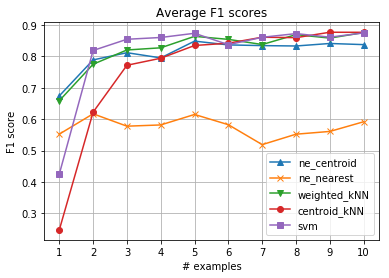

In [8]:
markers = ['^', 'x', 'v', 'o', 's']
fig = plt.figure()
i = 0
for model, f1_scores_list in f1_by_model.items():
    ax = plt.plot(N_EXAMPLES, f1_scores_list, marker=markers[i], label=model)
    i += 1
plt.grid()
plt.xticks(N_EXAMPLES)
plt.xlabel('# examples')
plt.ylabel('F1 score')
plt.legend()
plt.title('Average F1 scores')

### Print results